# DCBHs from HR of PBHs

In this notebook, we calculate the Hawking Radiation properties of Primordial Black Holes and examine their potential to contribute to the _Direct Collapse Black Hole_ scenario for the formation of SMBHs in early galaxies.

__Main idea__: As PBHs evaporate, they provide radiation that can keep a primordial gas halo hot enough to avoid collapse and fragmentation to smaller stars.

### Table of contents <a name="toc"></a>

1. [Age with redshift](#time_redshift)
2. [Hawking Temperature with BH mass](#HR_Mbh)
3. [Blackbody Spectra](#Blackbody)
4. [Connection of energy and frequency/wavelength of photons](#Photons)
5. [Evaporation of BHs](#BH_evaporation)
6. [PBHs mass functions](#PBH_masses)

__Importing modules and constants__

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from support import *

In [3]:
hbar*c/(8*pi*G*const.electron_mass)*1e3

2.0690085484788984e+16

In [10]:
np.log10(6.17e-12*M_SOLAR_2_GRAMS)

22.088919947157677

In [11]:
10**0.088919947157677

1.2272129999999992

In [14]:
c_SB, h, k

(5.670374419e-08, 6.62607015e-34, 1.380649e-23)

In [15]:
3*c_SB*hbar**4*c**6/(256*pi**3*k**4*G**2)

1.188851723670213e+16

In [18]:
3*c_SB*hbar**4*c**6/(256*pi**3*k**4*G**2)*YEARS_2_SEC*1e9*1e9

3.744882929561172e+41

In [19]:
(3*c_SB*hbar**4*c**6/(256*pi**3*k**4*G**2)*YEARS_2_SEC*1e9*1e9)/M_SOLAR_2_GRAMS**3

4.75919934562546e-59

In [25]:
14*4.76, 19*3, 58/3, 6.17/4**(1/3), 19.3-8

(66.64, 57, 19.333333333333332, 3.886856438925684, 11.3)

In [28]:
10**0.3*3.8868

7.755185565821041

In [34]:
1/(HUBBLE_CONST*KM_2_MPC)*2/3/np.sqrt(1-OMEGA_M)/YEARS_2_SEC/1e9*4.76

53.090042089449845

In [41]:
(np.log((np.sqrt((1-OMEGA_M)/(1+15)**3)+np.sqrt((1-OMEGA_M)/(1+15)**3+OMEGA_M))/np.sqrt(OMEGA_M))*53*1e-59+2.35*1e-64)**(1/3)

2.3299702583836144e-20

In [36]:
np.log((np.sqrt(1-OMEGA_M)+1)/np.sqrt(OMEGA_M))*1/(HUBBLE_CONST*KM_2_MPC)*2/3/np.sqrt(1-OMEGA_M)/YEARS_2_SEC/1e9*4.76

64.23550651722898

In [43]:
6.17*4.76/3

9.789733333333333

In [47]:
np.log10((2.33*1e-20)**(-4)*1e-66)

12.530576315895924

In [9]:
(2.35*1e-34)**(1/3)

6.1710057927767265e-12

In [5]:
(8*4.76/7*1e-59)**(1/3)

3.7890729487436476e-20

In [12]:
(7/8*6.17**3/4.76)

43.17741047794117

## Things to add:

2) Compare different evaporation times with different eras of the universe (function of $z$)
4) Intensity with distance
7) Add more careful description of DCBH requirements
8) Half-time for initial mass (Gyr)

# Hawking Temperature with BH mass <a name="HR_Mbh"></a>

The temperature of a BH as a function of mass, in the case of Schwarzschild BHs, is given by:

$$
T = \frac{\hbar c^3}{8 \pi k_B G} \frac{1}{M_{\rm BH}}
$$

Return to TOC [here](#toc).

Sanity check: $T \sim 10^{-7}$ K, for $M=M_\odot$.

In [9]:
print(f"The T_HR for 1 Mo BH is: {Hawking_temperature_from_mass(1)}")
print(f"The T_HR for 1 Mo BH is: {Hawking_temperature_from_mass(M_SOLAR_2_GRAMS, units='cgs')}")

The T_HR for 1 Mo BH is: 6.165330002985011e-08
The T_HR for 1 Mo BH is: 6.165330002985011e-08


In [4]:
BH_masses = np.logspace(15, 37, 200)
HR_temperatures = Hawking_temperature_from_mass(BH_masses, units='cgs')

In [5]:
example_masses = {"Asteroid": 1e-14, "MACHO": 1e-2, "Sun": 1, "LIGO (BHs)": 30}  # Test masses in solar units

example_T = np.zeros(len(example_masses))

for i, items in enumerate(list(example_masses)):
    example_T[i] = Hawking_temperature_from_mass(example_masses[items], units='solar')

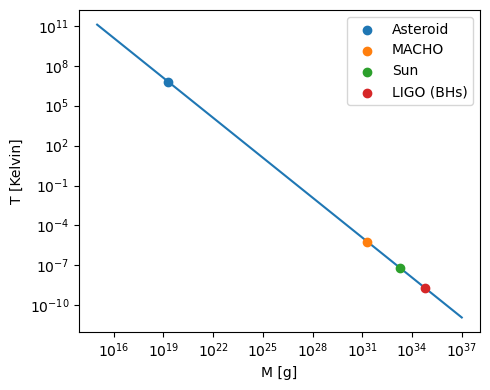

In [6]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(BH_masses, HR_temperatures)

for i, items in enumerate(list(example_masses)):
    ax1.scatter(example_masses[items]*M_SOLAR_2_GRAMS, example_T[i], label=f"{items}", zorder=100)
    
ax1.set_xlabel(r"M [g]")
ax1.set_ylabel("T [Kelvin]")


plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Blackbody Spectra <a name="Blackbody"></a>

$$
B_{\nu}=\frac{2h\nu^3}{c^2}\frac{1}{\exp[h\nu/k_{B}T]-1}=\frac{2h\nu^3}{c^2}\frac{1}{\exp[16\pi^2 G M_{\rm BH}\nu /c^3]-1}
$$

Return to TOC [here](#toc).

In [10]:
frequencies = np.linspace(1, 3e15, 100)
Temperatures = [1000, 3000, 5780, 8000, 10_000]

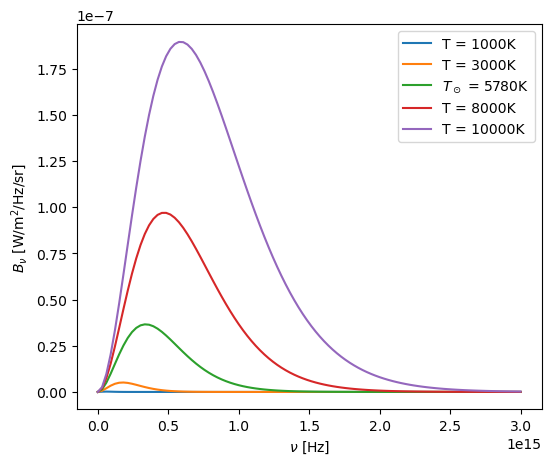

In [20]:
fig= plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

for T in Temperatures:
    if T==5780:
        ax.plot(frequencies, Spectrum_freq_temperature(frequencies, T),\
                label = fr"$T_\odot$ = {T}K")
    else:
        ax.plot(frequencies, Spectrum_freq_temperature(frequencies, T), label = f"T = {T}K")
    

ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")

plt.legend()
plt.show()

In [13]:
example_temp = {"CMB": 2.76, "H20 Boil": 373, "Sun": 5780}  # Test T in K

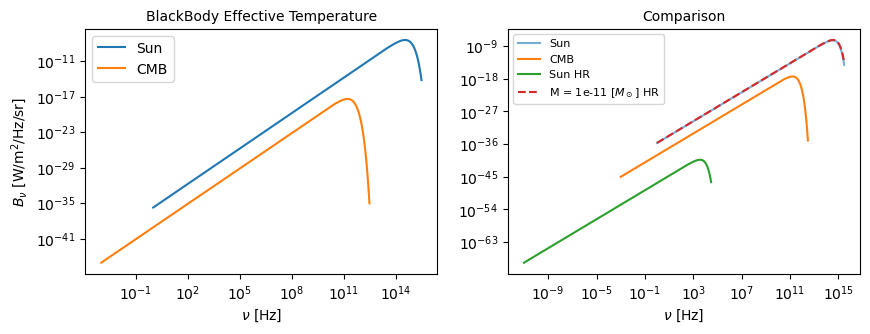

In [21]:
fig= plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)


ax1.loglog(frequencies, Spectrum_freq_temperature(frequencies, example_temp["Sun"]),\
        label = "Sun")
ax1.loglog(frequencies/1e3, Spectrum_freq_temperature(frequencies/1e3, example_temp["CMB"]),\
        label = "CMB")
ax1.set_xlabel(r"$\nu$ [Hz]")
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title("BlackBody Effective Temperature", fontsize=10)
ax1.legend()

ax2.loglog(frequencies, Spectrum_freq_temperature(frequencies, example_temp["Sun"]),\
        label = "Sun", alpha=0.6)
ax2.loglog(frequencies/1e3, Spectrum_freq_temperature(frequencies/1e3, example_temp["CMB"]),\
        label = "CMB")
ax2.loglog(frequencies/1e11, Spectrum_freq_mass(frequencies/1e11, example_masses["Sun"]),\
        label = "Sun HR")
ax2.loglog(frequencies, Spectrum_freq_mass(frequencies, 1e-11),\
        label = r"M = 1e-11 [$M_\odot$] HR", ls='--')
ax2.set_xlabel(r"$\nu$ [Hz]")
ax2.set_title("Comparison", fontsize=10)
ax2.legend(fontsize=8)

plt.tight_layout
plt.show()

### Blackbody spectrum for multiple masses

In [4]:
list_of_masses = [1, 2, 3, 4]
frequencies = np.linspace(1, 1e4, 100)
blackbody_spectrum = total_blackbody_spectrum(frequencies, list_of_masses)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


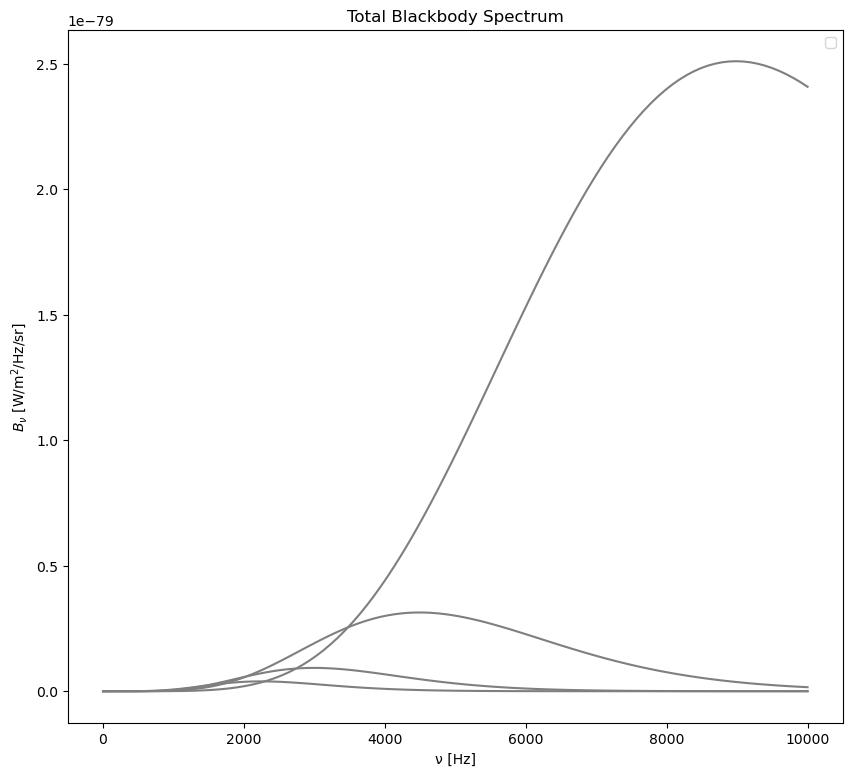

In [6]:
fig = plt.figure(figsize = (10, 9))
ax1 = fig.add_subplot(111)

for mass in list_of_masses:
    # ax1.plot(frequencies, Spectrum_freq_mass(frequencies, mass), c='tab:blue', ls='--')
    ax1.plot(frequencies, Greybody_spectrum_freq_mass(frequencies, mass), c='tab:grey', ls='-')
        
ax1.set_xlabel('ν [Hz]')
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title('Total Blackbody Spectrum')
ax1.legend()
plt.show()

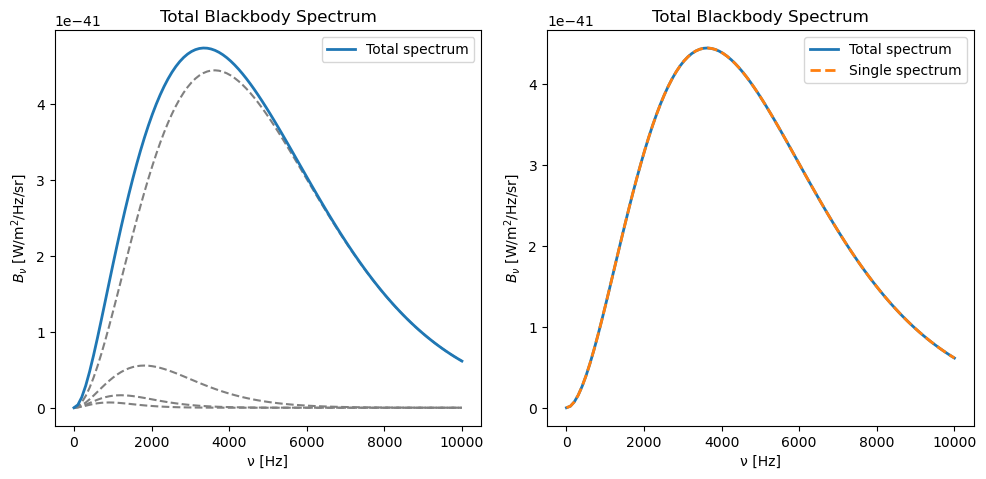

In [25]:
fig = plt.figure(figsize = (10, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

for mass in list_of_masses:
    ax1.plot(frequencies, Spectrum_freq_mass(frequencies, mass), c='grey', ls='--')
        
ax1.plot(frequencies, blackbody_spectrum, label='Total spectrum', lw=2)
ax1.set_xlabel('ν [Hz]')
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title('Total Blackbody Spectrum')
ax1.legend()

## Testing that the multiple spectrum from 1 mass is the same as the single spectrum
ax2.plot(frequencies, total_blackbody_spectrum(frequencies, [1]), label='Total spectrum', lw=2)
ax2.plot(frequencies, Spectrum_freq_mass(frequencies, 1), label='Single spectrum', lw=2, ls='--')
ax2.set_xlabel('ν [Hz]')
ax2.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax2.set_title('Total Blackbody Spectrum')
ax2.legend()

plt.tight_layout()
plt.show()

# Connection of energy and frequency/wavelength of photons <a name="Photons"></a>

Return to TOC [here](#toc).

Sanity checks:

1) For 1 Hz, we get $4.136 \cdot 10^{-15}$ eV.
2) For 1 nm, we get $1239.8$ eV.

In [26]:
print(f"For 1 Hz, we get {energy_from_photons(nu=1)} eV.")
print(f"For 1 nm, we get {energy_from_photons(wavelength=1)} eV.")

For 1 Hz, we get 4.13599298763e-15 eV.
For 1 nm, we get 1239.9395040323614 eV.


In [27]:
print(f"For 4.136e-15 eV, we get {photons_from_energy(4.136e-15)[0]} Hz.")
print(f"For 1239.8 eV, we get {photons_from_energy(1239.8)[1]} nm.")

For 4.136e-15 eV, we get 1.0000016954501667 Hz.
For 1239.8 eV, we get 1.0001125214005173 nm.


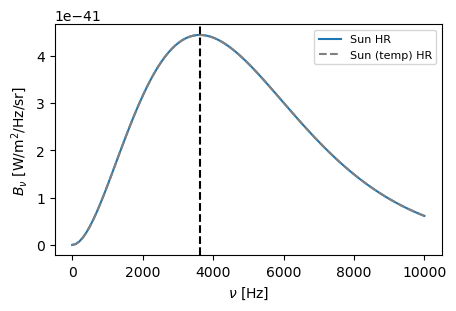

In [29]:
frequencies = np.linspace(1, 1e4, 100)

fig= plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)

ax1.plot(frequencies, Spectrum_freq_mass(frequencies, example_masses["Sun"]),\
        label = "Sun HR")
ax1.plot(frequencies, Spectrum_freq_temperature(frequencies,\
                                                     Hawking_temperature_from_mass(example_masses["Sun"])),\
        label = "Sun (temp) HR", ls='--', c='grey')


# We calculate the peak of the spectrum using Stefan-Boltzmann law (for a given mass)
ax1.axvline(x = photons_from_energy(peak_HR_energy_from_mass(example_masses["Sun"]))[0], ls='--', c='black')

ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_xlabel(r"$\nu$ [Hz]")
ax1.legend(fontsize=8)

plt.tight_layout
plt.show()

The Lyman-Werner photons correspond to the $11.2-13.6$ eV energy range. What is the frequency and wavelength range?

In [30]:
nu_low, lamda_low = photons_from_energy(11.2)
nu_high, lamda_high = photons_from_energy(13.6)

In [32]:
print(f"The low energy (11.2 eV) corresponds to: {np.round(nu_low, 2)} Hz, and {np.round(lamda_low, 2)} nm.")
print(f"The high energy (13.2 eV) corresponds to: {np.round(nu_high, 2)} Hz, and {np.round(lamda_high, 2)} nm.")

The low energy (11.2 eV) corresponds to: 2707934958665828.0 Hz, and 110.71 nm.
The high energy (13.2 eV) corresponds to: 3288206735522791.5 Hz, and 91.17 nm.


# Age with redshift <a name="time_redshift"></a>

In this section we connect the age of the universe since the BB, with redshift. We combine this with PBH formation and evolution due to Hawking evaporation (in the next section).

Return to TOC [here](#toc).

__Sanity checks__: We compare the `Astropy` functions with the analytical `age_at_redshift`. We consider a flat LCDM universe with $\Omega_m = 0.3$ and $H_0 = 70$ Mpc/km/s.

In [7]:
# Age of the universe today in Gyrs
cosmo.age(0).value, age_at_redshift(0)

(13.466983947061877, 13.494854310342225)

In [8]:
redshift_range = np.linspace(10, 30, 100)
redshift_sparse = redshift_range[::20]

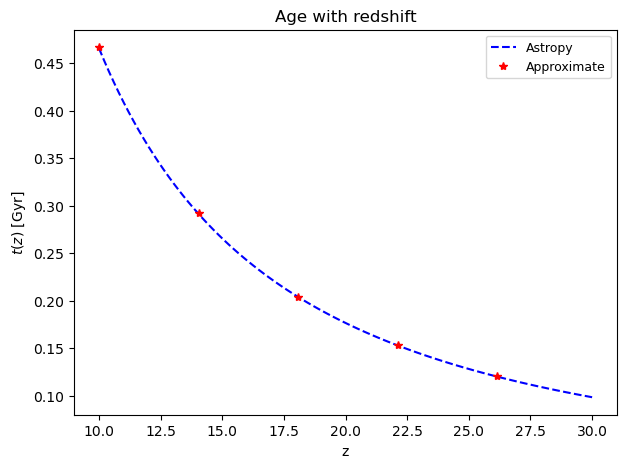

In [9]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(redshift_range, cosmo.age(redshift_range).value, label = 'Astropy', c='blue', ls='--')
ax1.plot(redshift_sparse, age_at_redshift(redshift_sparse), label = 'Approximate', c='red', ls=' ', marker='*')

ax1.set_ylabel('$t(z)$ [Gyr]')
ax1.set_xlabel('z')
ax1.set_title('Age with redshift')
ax1.legend(fontsize = 9)

plt.show()

# Evaporation time due to HR <a name="BH_evaporation"></a>

PBHs evolution with time, due to HR and comparison with common eras of the universe!

Return to TOC [here](#toc).

__Sanity check__: Comparison with analytical calculations: we expect for $1 M_\odot$ black hole, an evaporation time of $\sim 2 \cdot 10^{67}$ years.

In [10]:
print(f'The t_HR for a 1 Mo BH is: {evaporation_time_from_mass(1)} years.')

The t_HR for a 1 Mo BH is: 2.1043645818117622e+67 years.


In [11]:
print(f'The effective t_HR for a 1 Mo BH is: {effective_evaporation_time_from_mass(1)} years.')

The effective t_HR for a 1 Mo BH is: 2.1043645817433174e+67 years.


In [12]:
print(f'The t_HR for a 5e-20 Mo BH is: {evaporation_time_from_mass(5e-20)/1e9} Gyears.')

The t_HR for a 5e-20 Mo BH is: 2.6304557272647022 Gyears.


In [13]:
print(f'The t_HR for a 1e-19 Mo BH is: {evaporation_time_from_mass(1e-19)/1e9} Gyears.')

The t_HR for a 1e-19 Mo BH is: 21.043645818117618 Gyears.


In [19]:
mass_range = (np.linspace(1.4, 2.2, 10)*2.5e13)/M_SOLAR_2_GRAMS
mass_range_eff = (np.linspace(1.4, 2.2, 10)*1e14)/M_SOLAR_2_GRAMS

t_evap = evaporation_time_from_mass(mass_range)/1e9

t_evap_eff = np.zeros_like(mass_range_eff)
for idx, Mo in enumerate(mass_range_eff):
    t_evap_eff[idx] = effective_evaporation_time_from_mass(Mo)/1e9

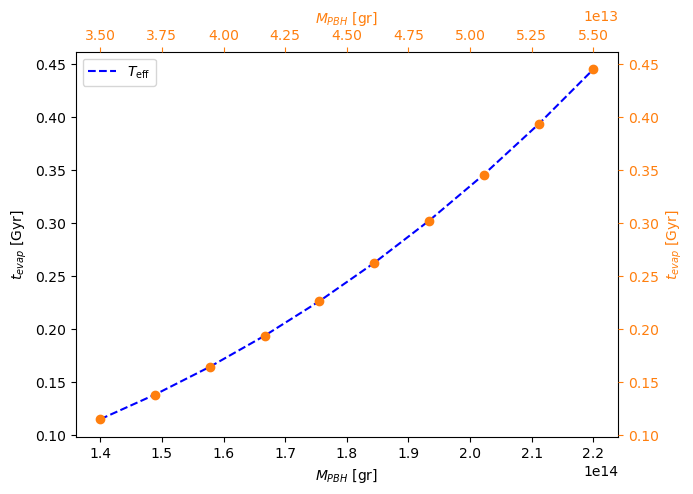

In [17]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax1.plot(mass_range_eff*M_SOLAR_2_GRAMS, t_evap, c='blue',\
         ls='--', label=r'$T_{\rm eff}$')
ax1.set_ylabel('$t_{evap}$ [Gyr]')
ax1.set_xlabel(r'$M_{PBH}$ [gr]')
ax1.legend()

ax2.scatter(mass_range*M_SOLAR_2_GRAMS, t_evap, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$M_{PBH}$ [gr]', color="C1") 
ax2.set_ylabel(r'$t_{evap}$ [Gyr]', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

plt.show()

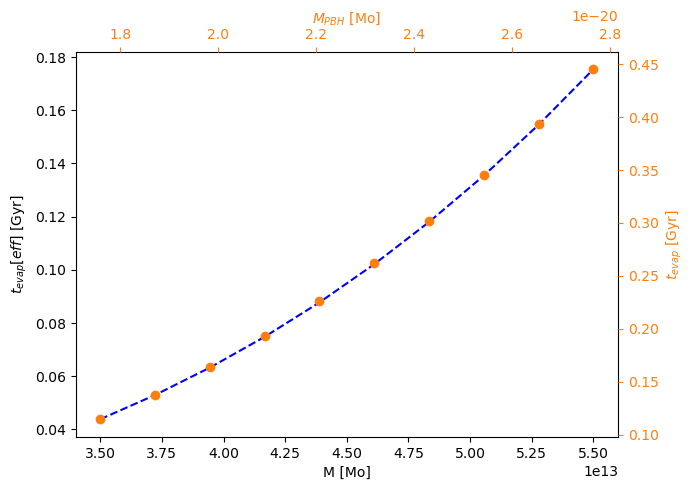

In [16]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax1.plot(mass_range*M_SOLAR_2_GRAMS, t_evap_eff, c='blue', ls='--')

ax1.set_ylabel('$t_{evap} [eff]$ [Gyr]')
ax1.set_xlabel('M [Mo]')

ax2.scatter(mass_range*M_SOLAR_2_GRAMS, t_evap, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$M_{PBH}$ [Mo]', color="C1") 
ax2.set_ylabel(r'$t_{evap}$ [Gyr]', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

plt.show()

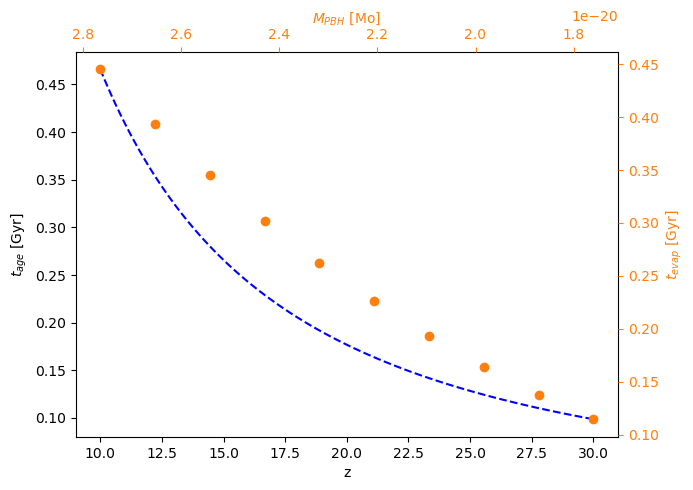

In [20]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax1.plot(redshift_range, cosmo.age(redshift_range).value, c='blue', ls='--')

ax1.set_ylabel('$t_{age}$ [Gyr]')
ax1.set_xlabel('z')

ax2.scatter(mass_range, t_evap, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$M_{PBH}$ [Mo]', color="C1") 
ax2.set_ylabel(r'$t_{evap}$ [Gyr]', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
ax2.invert_xaxis()

plt.show()

In [27]:
z_at_value(Planck18.age, [2, 7] * u.Gyr).value

array([3.19130393, 0.75378799])

In [42]:
mass_range

array([5.00000000e-20, 3.87131841e-20, 2.99742125e-20, 2.32079442e-20,
       1.79690683e-20, 1.39127970e-20, 1.07721735e-20, 8.34050269e-21,
       6.45774833e-21, 5.00000000e-21])

In [43]:
t_evap

array([2.63045573, 1.22094939, 0.56671451, 0.26304557, 0.12209494,
       0.05667145, 0.02630456, 0.01220949, 0.00566715, 0.00263046])

In [47]:
z_evap

array([  2.48375355,   4.83390656,   8.73160588,  15.21111507,
        25.9735917 ,  43.80903771,  73.25610962, 121.60785032,
       200.39101592, 327.45203013])

In [73]:
mass_range = np.logspace(-19.2, -19.8, 50)

t_evap = evaporation_time_from_mass(mass_range)/1e9  # To transform to Gyr
z_evap = z_at_value(Planck18.age, t_evap * u.Gyr, zmin=0).value

In [74]:
T_evap = Hawking_temperature_from_mass(mass_range, units='solar')

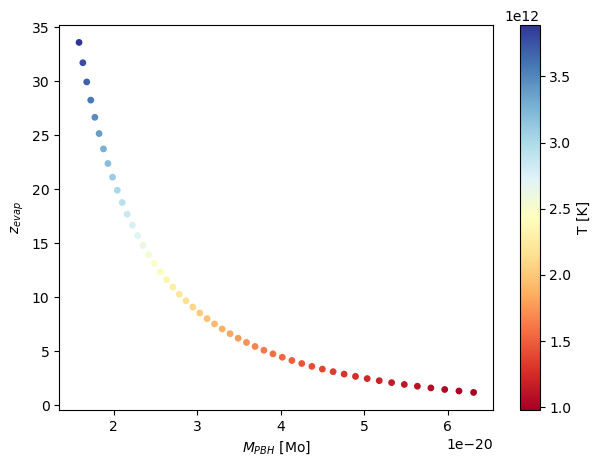

In [75]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)

cm = plt.cm.get_cmap('RdYlBu')
sc = ax1.scatter(mass_range, z_evap, s=15, c=T_evap, cmap=cm)

ax1.set_ylabel(r'$z_{evap}$')
ax1.set_xlabel(r'$M_{PBH}$ [Mo]')

plt.colorbar(sc, label='T [K]')
plt.show()

-------------------------------------

In [37]:
mass_range = np.logspace(-19, -20, 10)

t_evap = evaporation_time_from_mass(mass_range)/1e9  # To transform to Gyr

In [22]:
age_at_redshift(redshift_sparse)

array([12.19086367,  3.08204414,  1.47493938,  0.89957262,  0.62030967])

In [23]:
t_evap

array([21.04364582,  9.76759514,  4.53371606,  2.10436458,  0.97675951,
        0.45337161,  0.21043646,  0.09767595,  0.04533716,  0.02104365])

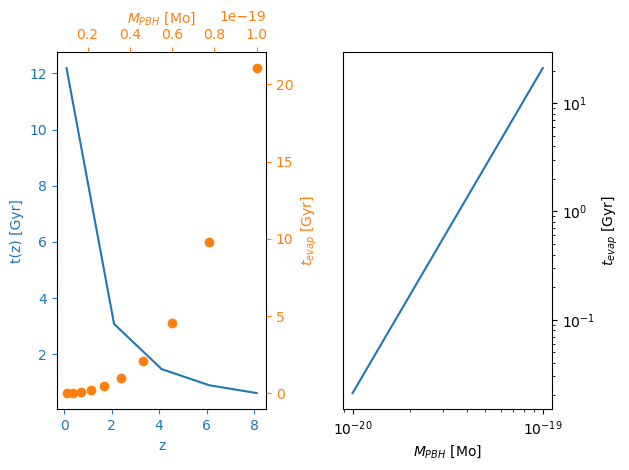

In [41]:
x_values1=[1,2,3,4,5]
y_values1=[1,2,2,4,1]

x_values2=[-1000,-800,-600,-400,-200]
y_values2=[10,20,39,40,50]

x_values3=[150,200,250,300,350]
y_values3=[10,20,30,40,50]


fig=plt.figure()
ax=fig.add_subplot(121, label="1")
ax2=fig.add_subplot(121, label="2", frame_on=False)
ax3=fig.add_subplot(122)


ax.plot(redshift_sparse, age_at_redshift(redshift_sparse), color="C0")
ax.set_xlabel("z", color="C0")
ax.set_ylabel("t(z) [Gyr]", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.scatter(mass_range, t_evap, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$M_{PBH}$ [Mo]', color="C1") 
ax2.set_ylabel(r'$t_{evap}$ [Gyr]', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")


ax3.loglog(mass_range, t_evap)
ax3.set_xlabel(r'$M_{PBH}$ [Mo]') 
ax3.set_ylabel(r'$t_{evap}$ [Gyr]')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right') 

plt.tight_layout()
plt.show()

In [62]:
z_range = np.logspace(-2, 5, 50)
# mass_range = np.logspace(-19.4, -19.9, 8)

mass_range = np.logspace(-20, -19, 8)


Z, M = np.meshgrid(z_range, mass_range)

# t_evap = evaporation_time_from_mass(mass_range)/1e9  # To transform to Gyr
# z_evap = z_at_value(Planck18.age, t_evap * u.Gyr, zmin=0).value

In [63]:
T_evolution = np.zeros((len(z_range), len(mass_range)))

for i, z_val in enumerate(z_range):
    for j, M_val in enumerate(mass_range):
        M_evolved = mass_evolution_from_HR(M_val, 1e3, z_val)
        
        if M_evolved>0:
            T_evolution[i, j] = Hawking_temperature_from_mass(M_evolved)

In [64]:
T_evolution[:,0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00927223e+13, 7.58725740e+12, 6.85945843e+12, 6.52821815e+12,
       6.35404426e+12, 6.25614714e+12, 6.19916012e+12, 6.16533000e+12,
       6.14501738e+12, 6.13273903e+12, 6.12528741e+12, 6.12075424e+12,
       6.11799252e+12, 6.11630856e+12, 6.11528122e+12, 6.11465428e+12,
       6.11427161e+12, 6.11403801e+12, 6.11389540e+12, 6.11380834e+12,
       6.11375518e+12, 6.11372273e+12])

In [33]:
M_evolved = mass_evolution_from_HR(1e-14, 1e3, 1e3)
M_evolved

9.99999999999998e-15

In [49]:
M_evolved = mass_evolution_from_HR(1e-19, 1e3, 1e-2)
M_evolved

7.148852559016955e-20

**MK NOTE**: Check units here!

In [3]:
initial_mass_with_Tcrit_and_z(10, 1e4)

1.226900670594014e+19

In [4]:
z_range = np.linspace(10, 30)

initial_mass_with_Tcrit_and_z(z_range, 1e4)

array([1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19, 1.22690067e+19, 1.22690067e+19,
       1.22690067e+19, 1.22690067e+19])

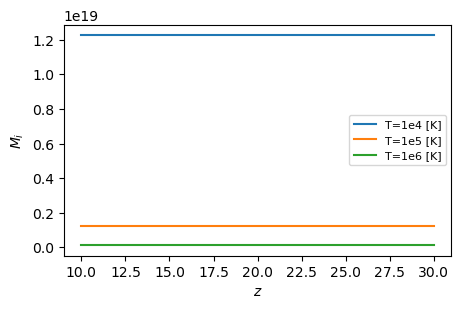

In [9]:
fig= plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)


for T in np.arange(4, 7):
    ax1.plot(z_range, initial_mass_with_Tcrit_and_z(z_range, 10**T),\
            label = f"T=1e{T} [K]")

ax1.set_ylabel(r"$M_i$")
ax1.set_xlabel(r"$z$")
ax1.legend(fontsize=8)

plt.show()

# Blackbody spectrum evolution with redshift

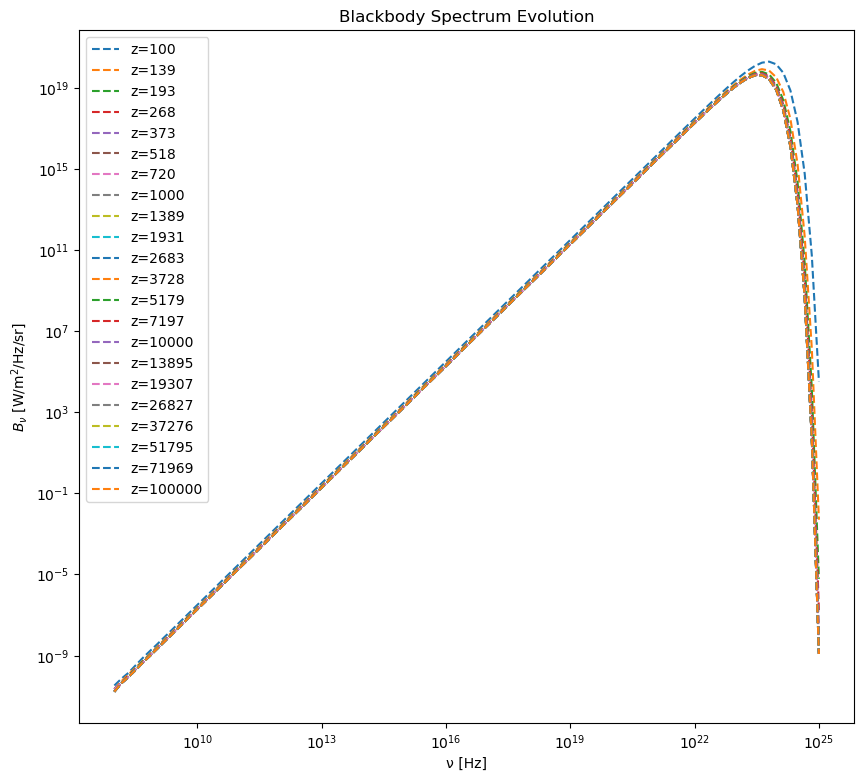

In [65]:
frequencies = np.logspace(8, 25, 100)

fig = plt.figure(figsize = (10, 9))
ax1 = fig.add_subplot(111)

for idx, T in enumerate(T_evolution[:, 0]):
    if T>0:
        ax1.loglog(frequencies, Spectrum_freq_temperature(frequencies, T), ls='--', label=f'z={round(z_range[idx])}')
        
ax1.set_xlabel('ν [Hz]')
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title('Blackbody Spectrum Evolution')
ax1.legend()

plt.show()

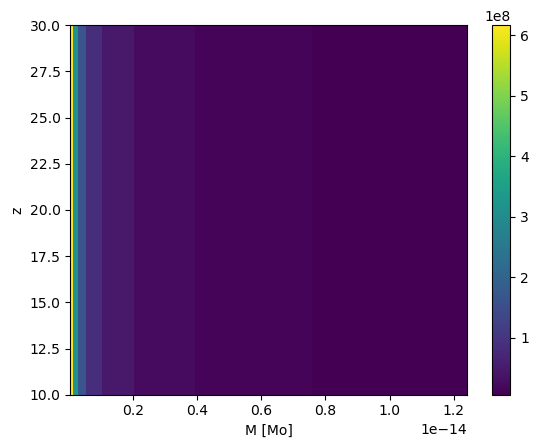

In [60]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

p = ax1.pcolormesh(M, Z, T_evolution.T)
# ax1.plot(mass_range, z_evap, ls='-', c='red', lw=4)
ax1.set_ylim(10, 30)
ax1.set_xlabel('M [Mo]')
ax1.set_ylabel('z')

plt.colorbar(p)
plt.show()

## Mass evolution of BHs due to HR

Due to the emission of HR, BHs reduce their mass. For a Schwarzschild BH, the rate of mass loss follows:

$$
\frac{dM}{dt} = -\frac{A}{M^2},\ {\rm with}\ A = ...
$$

Solving this equation, assuming BH formation time close to $t = 0$, gives a relation between masses and redshifts:

$$
M_f = \left[M_i^3 - C t(z, H_0, \Omega_m) \right]^{1/3}
$$

In [61]:

mass_evolution_from_HR(mass_range[0], 1000, time_units='redshift')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Primordial Black Holes Mass Functions <a name="PBH_masses"></a>

Primordial BHs can form when overdensities collapse in the early Universe. An estimate of their mass at formation is given by comparing the density of the universe with the density connected with a black hole of mass $M$ inside the Hubble radius. This gives:

$
M \sim \frac{c^3 t}{G} \sim 10^{15} \left(\frac{t}{10^{-23} {\rm s}}\right) {\rm gr}.
$

This estimate tells us that as soon as $1$ s after the Big Bang, we can have PBHs with masses of the order of $10^5 M_{\odot}$. So for our case, we can assume that a range of masses of PBHs would already be present at $z \sim 30$ or smaller, when they need to be present to provide the necessary radiation for DCBHs formation.

PBHs at formation time can have a range of masses, and a distribution that is very much dependent on the model. Useful link for more details [[here](https://arxiv.org/pdf/2402.03934.pdf)].

Here we study a:

- Lognormal mass function
- Power-law mass function
- Broken Power-law mass function
- Critical Collapse mass function

We initially reproduce the figure in the [[paper](https://arxiv.org/pdf/2402.03934.pdf)] (above). This means that we use a different mass range than what we expect for our scenario.

Return to TOC [here](#toc).

__1. Lognormal Mass Function__

In [73]:
pbh_mass_range = np.linspace(0.05, 20, 100)
lognormal_mass_function = lognormal_PBH_mass_function(pbh_mass_range, 50, 2)

In [74]:
masses_randoms = np.random.uniform(0.05, 20, size=5000)
weights = lognormal_PBH_mass_function(masses_randoms, 50, 2)/np.sum(lognormal_PBH_mass_function(masses_randoms, 50, 2))
random_masses_lognormal = np.random.choice(masses_randoms, replace=True, size=4000, p=weights)

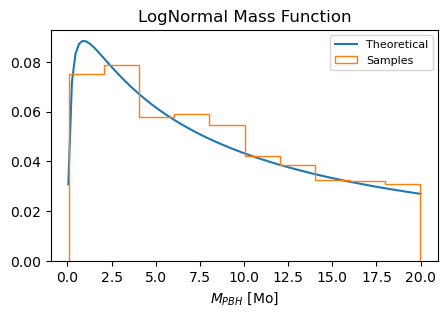

In [75]:
fig= plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)

ax1.plot(pbh_mass_range, lognormal_mass_function*3,\
        label = "Theoretical")

ax1.hist(random_masses_lognormal, density=True, histtype='step',\
        label = "Samples")

ax1.set_title('LogNormal Mass Function')
ax1.set_xlabel(r"$M_{PBH}$ [Mo]")
ax1.legend(fontsize=8)

plt.tight_layout
plt.show()

__2. Power-law Mass Function__

In [45]:
PBH_mass_range = np.linspace(5, 20, 100)
power_law_mass_function = power_law_PBH_mass_function(PBH_mass_range, 10, 2)

In [46]:
random_masses = np.random.uniform(5, 20, size = 5000)
weights = power_law_PBH_mass_function(random_masses, 10, 2)/np.sum(power_law_PBH_mass_function(random_masses, 10, 2))
random_masses_power_law = np.random.choice(random_masses, replace = True, size = 4000, p = weights)

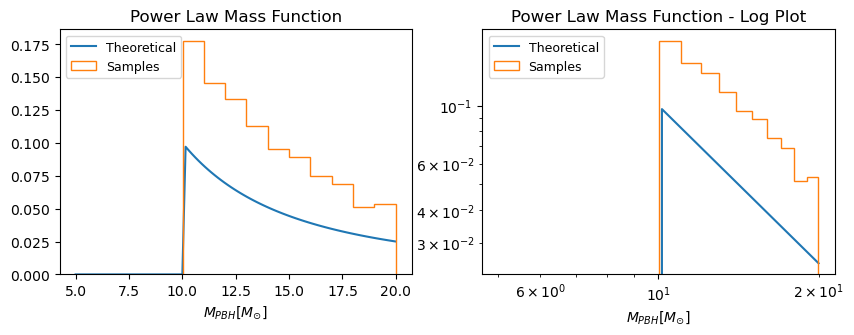

In [47]:
fig = plt.figure(figsize = (10, 7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(PBH_mass_range, power_law_mass_function, label = 'Theoretical')
ax1.hist(random_masses_power_law, density = True, histtype = 'step', label = 'Samples')
ax1.set_title('Power Law Mass Function')
ax1.set_xlabel('$M_{PBH} [M_{\odot}]$')
ax1.legend(fontsize = 9)

ax2.loglog(PBH_mass_range, power_law_mass_function, label = 'Theoretical')
ax2.hist(random_masses_power_law, density = True, histtype = 'step', label = 'Samples')
ax2.set_xlabel('$M_{PBH} [M_{\odot}]$')
ax2.set_title('Log Plot')
ax2.set_title('Power Law Mass Function - Log Plot')
ax2.legend(fontsize = 9)


plt.tight_layout
plt.show()

__3. Broken Power-law Mass Function__

In [48]:
PBH_mass_range = np.linspace(0.05, 20, 100)
broken_pl_mass_function = broken_pl_PBH_mass_function(PBH_mass_range, 10, 1, 2)

In [49]:
random_masses = np.random.uniform(0.05, 20, size = 5000)
weights = broken_pl_PBH_mass_function(random_masses, 10, 1, 2)/np.sum(broken_pl_PBH_mass_function(random_masses, 10, 1, 2))
random_masses_broken_pl = np.random.choice(random_masses, replace = True, size = 4000, p = weights)

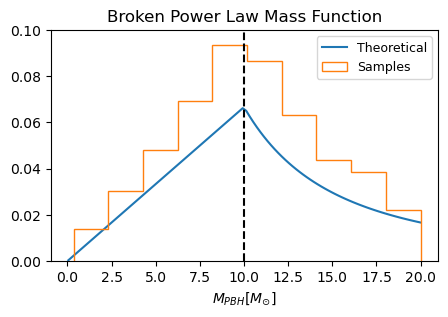

In [50]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(PBH_mass_range, broken_pl_mass_function, label = 'Theoretical')
ax1.hist(random_masses_broken_pl, density = True, histtype = 'step', label = 'Samples')

ax1.set_xlabel('$M_{PBH} [M_{\odot}]$')
ax1.set_title('Broken Power Law Mass Function')
ax1.legend(fontsize = 9)
ax1.set_ylim([0, 0.1])

ax1.axvline(x = 10, color = 'black', linestyle = '--')

plt.tight_layout
plt.show()

__4. Critical Collapse Mass Function__

In [51]:
PBH_mass_range = np.linspace(0.05, 20, 100)
crit_collapse_mass_function = crit_collapse_PBH_mass_function(PBH_mass_range, 10, 1.5)

In [52]:
random_masses = np.random.uniform(0.05, 20, size = 5000)
weights = crit_collapse_PBH_mass_function(random_masses, 10, 1.5)/np.sum(crit_collapse_PBH_mass_function(random_masses, 10, 1.5))
random_masses_crit_collapse = np.random.choice(random_masses, replace = True, size = 4000, p = weights)

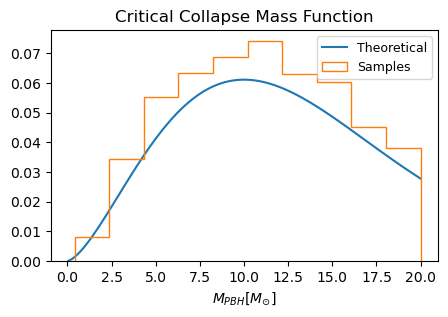

In [53]:
fig = plt.figure(figsize = (5, 3))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(PBH_mass_range, crit_collapse_mass_function, label = 'Theoretical')
ax1.hist(random_masses_crit_collapse, density = True, histtype = 'step', label = 'Samples')

ax1.set_xlabel('$M_{PBH} [M_{\odot}]$')
ax1.set_title('Critical Collapse Mass Function')
ax1.legend(fontsize = 9)

plt.tight_layout
plt.show()

### Comparison of PBH mass functions

In [63]:
PBH_mass_range = np.linspace(1, 100, 200)
lognormal_mass_function = normalise(lognormal_PBH_mass_function(PBH_mass_range, 30, 1))
power_law_mass_function = normalise(power_law_PBH_mass_function(PBH_mass_range, 8, 1.5))
broken_pl_mass_function = normalise(broken_pl_PBH_mass_function(PBH_mass_range, 30, 0.2, 2))
crit_collapse_mass_function = normalise(crit_collapse_PBH_mass_function(PBH_mass_range, 20, 1))

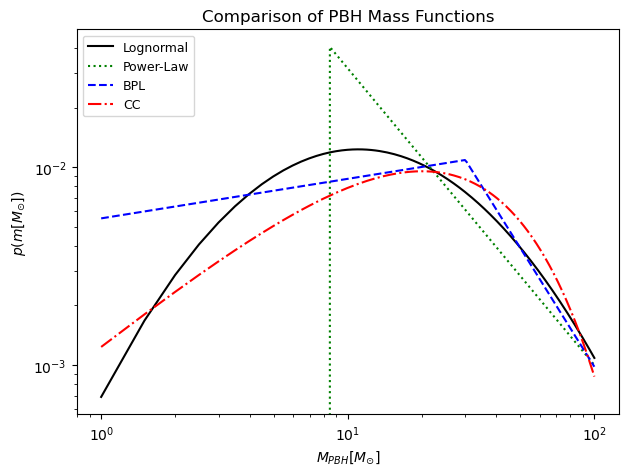

In [64]:
fig = plt.figure(figsize = (7, 5))
ax1 = fig.add_subplot(1, 1, 1)

ax1.loglog(PBH_mass_range, lognormal_mass_function, label = 'Lognormal', c='black')
ax1.loglog(PBH_mass_range, power_law_mass_function, label = 'Power-Law', c='green', ls=':')
ax1.loglog(PBH_mass_range, broken_pl_mass_function, label = 'BPL', c='blue', ls='--')
ax1.loglog(PBH_mass_range, crit_collapse_mass_function, label = 'CC', c='red', ls='-.')

ax1.set_ylabel('$p(m [M_{\odot}])$')
ax1.set_xlabel('$M_{PBH} [M_{\odot}]$')
ax1.set_title('Comparison of PBH Mass Functions')
ax1.legend(fontsize = 9, loc='upper left')


plt.show()

#### Total blackbody spectrum from random masses selected from the different mass functions

In [84]:
frequencies = np.linspace(1, 1e7, 1000)

blackbody_spectrum_ln = total_blackbody_spectrum(frequencies, random_masses_lognormal)
blackbody_spectrum_pl = total_blackbody_spectrum(frequencies, random_masses_power_law)
blackbody_spectrum_pbl = total_blackbody_spectrum(frequencies, random_masses_broken_pl)
blackbody_spectrum_cc = total_blackbody_spectrum(frequencies, random_masses_crit_collapse)

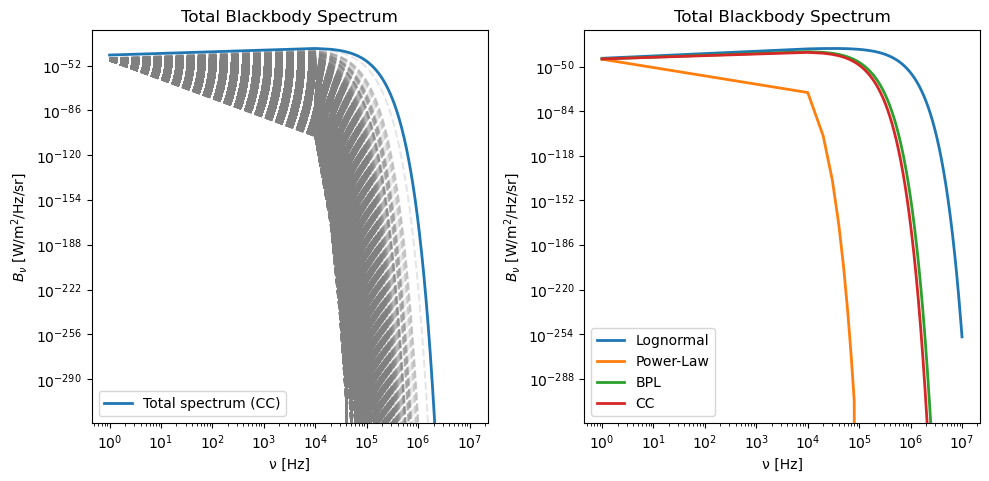

In [85]:
fig = plt.figure(figsize = (10, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

for mass in random_masses_crit_collapse:
    ax1.loglog(frequencies, Spectrum_freq_mass(frequencies, mass), c='grey', ls='--', alpha=0.2)
        
ax1.loglog(frequencies, blackbody_spectrum_cc, label='Total spectrum (CC)', lw=2)
ax1.set_xlabel('ν [Hz]')
ax1.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax1.set_title('Total Blackbody Spectrum')
ax1.legend()


ax2.loglog(frequencies, blackbody_spectrum_ln, label='Lognormal', lw=2)
ax2.loglog(frequencies, blackbody_spectrum_pl, label='Power-Law', lw=2)
ax2.loglog(frequencies, blackbody_spectrum_pbl, label='BPL', lw=2)
ax2.loglog(frequencies, blackbody_spectrum_cc, label='CC', lw=2)

ax2.set_xlabel('ν [Hz]')
ax2.set_ylabel(r"$B_{\nu}$ [W/m$^2$/Hz/sr]")
ax2.set_title('Total Blackbody Spectrum')
ax2.legend()


plt.tight_layout()
plt.show()

# Luminosity for DCBHs

The presence of SMBHs with masses in the region of $10^9 M_\odot$ at the first billion years of the universe requires the growth or formation of massive BHs at high redshifts ($z>10$). There are various channels for the production of massive BHs, but in this project 

Lyman-Werner background: $11.2-13.6$ eV

In [39]:
# Finding the frequency range that corresponds to this energy range

E_low = 11.2
E_high = 13.6

nu_low = photons_from_energy(E_low)[0]
nu_high = photons_from_energy(E_high)[0]

print(f"The photon energy: {E_low} eV correspond to: {nu_low} Hz")
print(f"The photon energy: {E_high} eV correspond to: {nu_high} Hz")

The photon energy: 11.2 eV correspond to: 2707934958665828.0 Hz
The photon energy: 13.6 eV correspond to: 3288206735522791.5 Hz


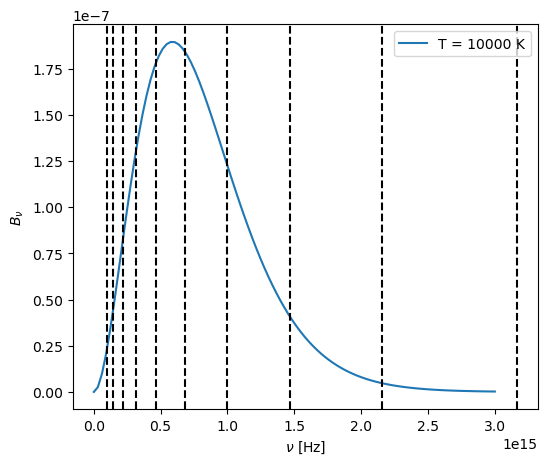

In [40]:
Radius = 20
Temp = 10000

frequencies = np.linspace(1, 3e15, 100)
max_frequencies = np.logspace(14, 15.5, 10)

fig= plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

ax.plot(frequencies, Spectrum_freq_temperature(frequencies, Temp), label = f"T = {Temp} K")

for max_nu in max_frequencies:
    ax.axvline(x=max_nu, ls='--', c='black')

ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$B_{\nu}$")

plt.legend()
plt.show()

In [41]:
v_min = 1

integral_lum_quad = np.zeros_like(max_frequencies)
integral_lum_simpson = np.zeros_like(max_frequencies)

for i, freq in enumerate(max_frequencies):
    integral_lum_quad[i] = 4*pi**2*Radius**2*quad(Spectrum_freq_temperature, v_min, freq, args=(Temp))[0]
    frequencies = np.linspace(v_min, freq, 100)
    integral_lum_simpson[i] = 4*pi**2*Radius**2*simpson(Spectrum_freq_temperature(frequencies, Temp), frequencies)

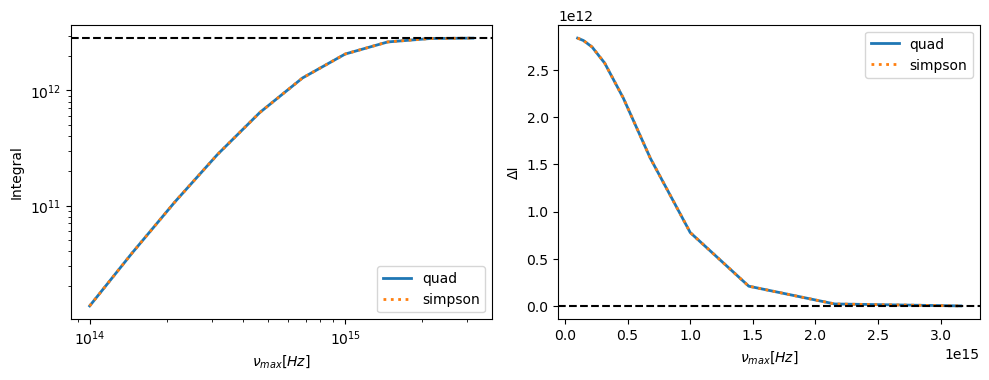

In [42]:
fig = plt.figure(figsize = (10, 7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.loglog(max_frequencies, integral_lum_quad, label='quad', lw=2)
ax1.loglog(max_frequencies, integral_lum_simpson, label='simpson', lw=2, ls=':')
ax1.axhline(y = theoretical_lum(Radius, Temp), color = 'black', linestyle = '--')
ax1.set_xlabel('$ν_{max} [Hz]$')
ax1.set_ylabel('Integral')
ax1.legend()

ax2.plot(max_frequencies, theoretical_lum(Radius, Temp) - integral_lum_quad, label='quad', lw=2)
ax2.plot(max_frequencies, theoretical_lum(Radius, Temp) - integral_lum_simpson, label='simpson', lw=2, ls=':')
ax2.axhline(y = 0, color = 'black', linestyle = '--')
ax2.set_xlabel('$ν_{max} [Hz]$')
ax2.set_ylabel('ΔI')
ax2.legend()

plt.tight_layout()
plt.show()

__Integrating at a specific frequency range__

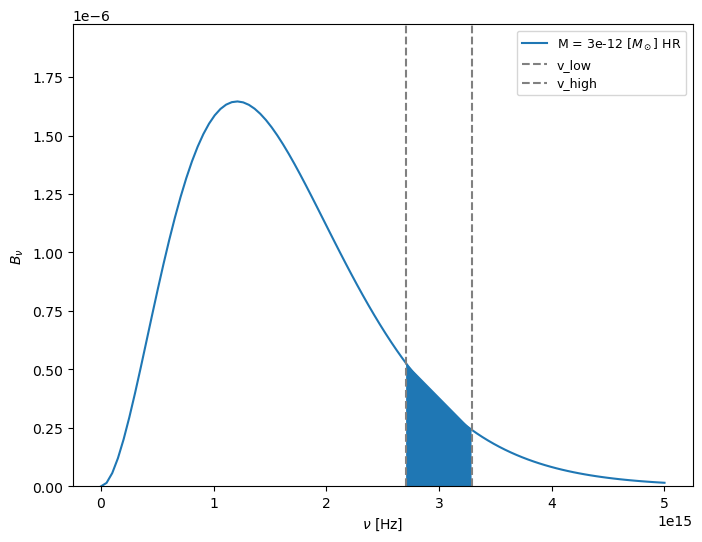

In [43]:
frequencies = np.linspace(1, 5e15, 100)

fig= plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(frequencies, Spectrum_freq_mass(frequencies, 3e-12), label = r"M = 3e-12 [$M_\odot$] HR")
ax.fill_between([nu_low, nu_high], [Spectrum_freq_mass(nu_low, 3e-12), Spectrum_freq_mass(nu_high, 3e-12)], 0)
ax.axvline(x=nu_low, label='v_low', ls='--', c='grey')
ax.axvline(x=nu_high, label='v_high', ls='--', c='grey')

ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$B_{\nu}$")
ax.set_ylim(0, 1.2*np.max(Spectrum_freq_mass(frequencies, 3e-12)))

plt.legend(fontsize=9)
plt.show()

In [44]:
# Integral in frequency range of interest
freq_range = np.linspace(nu_low, nu_high, 400)
simpson(Spectrum_freq_mass(freq_range, 3e-12), freq_range)

214450022.16161394

In [45]:
simpson(Spectrum_freq_mass(freq_range, 3e-12), freq_range)/simpson(Spectrum_freq_mass(frequencies, 3e-12), frequencies)*100

6.67877051964956

In [46]:
Spectrum_freq_mass(nu_low, 3e-12), Spectrum_freq_mass(nu_high, 3e-12)

(5.259704990159456e-07, 2.425694182453482e-07)

--------------------------

### Greybody factors check

In [24]:
2+2

4

In [62]:
check_greybody_factor(1e-13, 12)

False

In [56]:
photons_from_energy(1e-5)[1]/1e9<=Schwarzschild_radius(10)

True

In [47]:
Schwarzschild_radius(1)

2955.6117871092288